In [1]:
%matplotlib inline

In [2]:
import numpy as np
import bcolz
import threading
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D, Activation
from keras.layers.core import Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import add
from keras.applications.vgg16 import VGG16
import keras.backend as K
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [3]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

https://groups.google.com/forum/#!topic/bcolz/bHHT3wjzFa4

In [4]:
arr_lr = bcolz.open('trn_resized_72.bc', 'r')
arr_lr = bcolz.carray(arr_lr, chunklen=16)
arr_hr = bcolz.open('trn_resized_288.bc', 'r')
arr_hr = bcolz.carray(arr_hr, chunklen=16)

In [5]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Conv2D(filters, (size, size), strides=stride, padding=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

In [6]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return add([x, ip])

In [7]:
def up_block(x, filters, size):
    x = UpSampling2D()(x)
    x = Conv2D(filters, (size, size), padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [8]:
def get_model(arr):
    inp=Input(arr.shape[1:])
    x=conv_block(inp, 64, 9, (1,1))
    for i in range(4): x=res_block(x)
    x=up_block(x, 64, 3)
    x=up_block(x, 64, 3)
    x=Conv2D(3, (9, 9), activation='tanh', padding='same')(x)
    outp=Lambda(lambda x: (x+1)*127.5)(x)
    return inp,outp

In [9]:
inp,outp=get_model(arr_lr)

In [10]:
shp = arr_hr.shape[1:]

vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [11]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [12]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [13]:
w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [14]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
m_sr.compile('adam', 'mae')

In [15]:
class BcolzArrayIterator(object):
    """
    Returns an iterator object into Bcolz carray files
    Original version by Thiago Ramon Gonçalves Montoya
    Docs (and discovery) by @MPJansen
    Refactoring, performance improvements, fixes by Jeremy Howard j@fast.ai
        :Example:
        X = bcolz.open('file_path/feature_file.bc', mode='r')
        y = bcolz.open('file_path/label_file.bc', mode='r')
        trn_batches = BcolzArrayIterator(X, y, batch_size=64, shuffle=True)
        model.fit_generator(generator=trn_batches, samples_per_epoch=trn_batches.N, nb_epoch=1)
        :param X: Input features
        :param y: (optional) Input labels
        :param w: (optional) Input feature weights
        :param batch_size: (optional) Batch size, defaults to 32
        :param shuffle: (optional) Shuffle batches, defaults to false
        :param seed: (optional) Provide a seed to shuffle, defaults to a random seed
        :rtype: BcolzArrayIterator
        >>> A = np.random.random((32*10 + 17, 10, 10))
        >>> c = bcolz.carray(A, rootdir='test.bc', mode='w', expectedlen=A.shape[0], chunklen=16)
        >>> c.flush()
        >>> Bc = bcolz.open('test.bc')
        >>> bc_it = BcolzArrayIterator(Bc, shuffle=True)
        >>> C_list = [next(bc_it) for i in range(11)]
        >>> C = np.concatenate(C_list)
        >>> np.allclose(sorted(A.flatten()), sorted(C.flatten()))
        True
    """

    def __init__(self, X, y=None, w=None, batch_size=32, shuffle=False, seed=None):
        if y is not None and len(X) != len(y):
            raise ValueError('X (features) and y (labels) should have the same length'
                             'Found: X.shape = %s, y.shape = %s' % (X.shape, y.shape))
        if w is not None and len(X) != len(w):
            raise ValueError('X (features) and w (weights) should have the same length'
                             'Found: X.shape = %s, w.shape = %s' % (X.shape, w.shape))
        if batch_size % X.chunklen != 0:
            raise ValueError('batch_size needs to be a multiple of X.chunklen')

        self.chunks_per_batch = batch_size // X.chunklen
        self.X = X
        self.y = y if y is not None else None
        self.w = w if w is not None else None
        self.N = X.shape[0]
        self.batch_size = batch_size
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.shuffle = shuffle
        self.seed = seed


    def reset(self): self.batch_index = 0


    def next(self):
        with self.lock:
            if self.batch_index == 0:
                if self.seed is not None:
                    np.random.seed(self.seed + self.total_batches_seen)
                self.index_array = (np.random.permutation(self.X.nchunks + 1) if self.shuffle
                    else np.arange(self.X.nchunks + 1))

            #batches_x = np.zeros((self.batch_size,)+self.X.shape[1:])
            batches_x, batches_y, batches_w = [],[],[]
            for i in range(self.chunks_per_batch):
                current_index = self.index_array[self.batch_index]
                if current_index == self.X.nchunks:
                    batches_x.append(self.X.leftover_array[:self.X.leftover_elements])
                    current_batch_size = self.X.leftover_elements
                else:
                    batches_x.append(self.X.chunks[current_index][:])
                    current_batch_size = self.X.chunklen
                self.batch_index += 1
                self.total_batches_seen += 1

                idx = current_index * self.X.chunklen
                if not self.y is None: batches_y.append(self.y[idx: idx + current_batch_size])
                if not self.w is None: batches_w.append(self.w[idx: idx + current_batch_size])
                if self.batch_index >= len(self.index_array):
                    self.batch_index = 0
                    break

            batch_x = np.concatenate(batches_x)
            if self.y is None: return batch_x

            batch_y = np.concatenate(batches_y)
            if self.w is None: return batch_x, batch_y

            batch_w = np.concatenate(batches_w)
            return batch_x, batch_y, batch_w


    def __iter__(self): return self

    def __next__(self, *args, **kwargs): return self.next(*args, **kwargs)

In [16]:
from tqdm import tqdm

In [17]:
def train(bs, niter=10):
    targ = np.zeros((bs, 1))
    bc = BcolzArrayIterator(arr_hr, arr_lr, batch_size=bs)
    for i in tqdm(range(niter)):
        hr,lr = next(bc)
        if hr.shape[0] != bs: continue
        m_sr.train_on_batch([lr[:bs], hr[:bs]], targ)

In [18]:
bc = BcolzArrayIterator(arr_hr, arr_lr, batch_size=16)
hr,lr = next(bc)
hr.shape[0]

16

In [19]:
its = len(arr_hr)//16; its

1214

In [20]:
train(16, 18000)

100%|██████████| 18000/18000 [9:20:08<00:00,  1.87s/it]  


In [21]:
K.set_value(m_sr.optimizer.lr, 1e-4)
train(16, 18000)

100%|██████████| 18000/18000 [9:19:44<00:00,  1.87s/it]  


In [22]:
top_model = Model(inp, outp)

In [23]:
p = top_model.predict(arr_lr[:20])

In [25]:
from PIL import Image

In [26]:
img = Image.open('fish2.jpg').resize((288,288))

In [27]:
img_dat = np.expand_dims(np.array(img),0)

In [29]:
import matplotlib.pyplot as plt

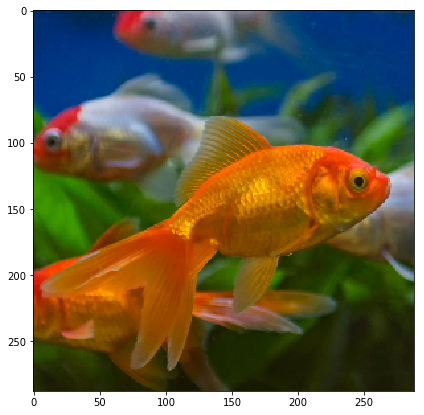

In [30]:
plt.figure(figsize=(7,7))
plt.imshow(img_dat[0]);

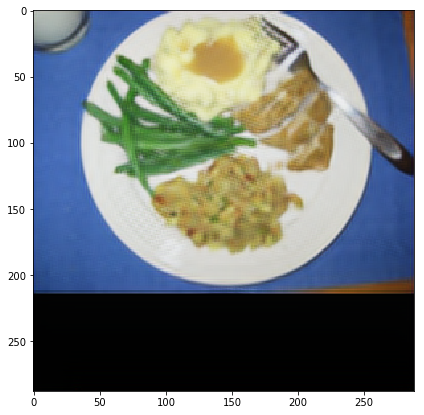

In [32]:
plt.figure(figsize=(7,7))
plt.imshow(p[0].astype('uint8'));

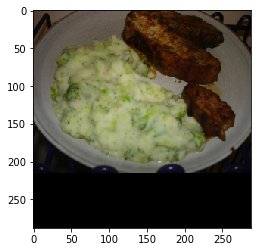

In [33]:
idx=4
plt.imshow(arr_hr[idx].astype('uint8'));

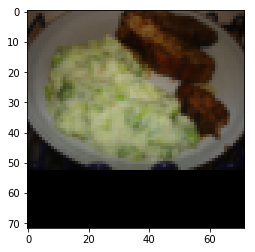

In [34]:
plt.imshow(arr_lr[idx].astype('uint8'));

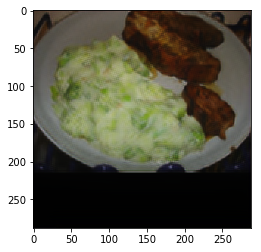

In [35]:
plt.imshow(p[idx].astype('uint8'));

In [36]:
inp,outp=get_model(arr_hr)
model_hr = Model(inp, outp)
for i in range(len(top_model.layers)):
    model_hr.layers[i].set_weights(top_model.layers[i].get_weights())

In [37]:
p = model_hr.predict(img_dat)

In [38]:
p = model_hr.predict(arr_hr[idx:idx+1])

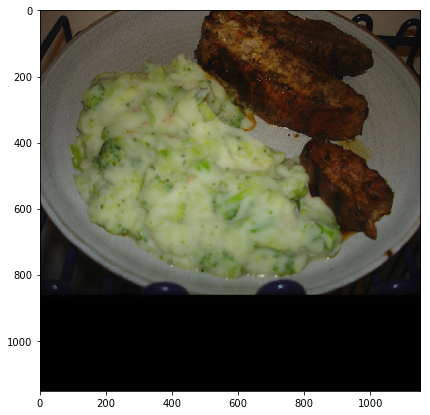

In [39]:
plt.figure(figsize=(7,7))
plt.imshow(p[0].astype('uint8'));

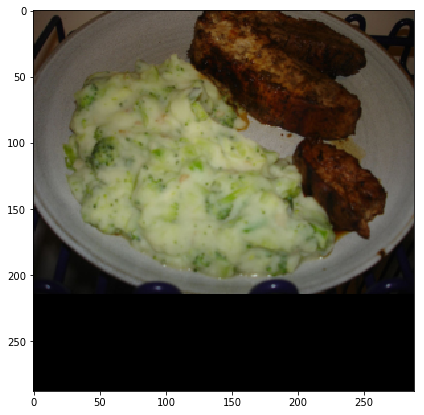

In [40]:
plt.figure(figsize=(7,7))
plt.imshow(arr_hr[idx].astype('uint8'));

In [41]:
top_model.save_weights('sr_final.h5')

In [42]:
top_model.load_weights('sr_final.h5')